In [57]:
import numpy as np
import pandas as pd
import pickle
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.stattools import coint
import datetime

### Find Tickers
We would like to identify cointegrated pairs.
One way to find them is to look into some specific sectors.
For exp: 'utilities.csv' includes a list of active utilities.

In [58]:
# filename='utilities.csv'
# filename='minerals.csv'
# filename='reit.csv'
# filename='etf.csv'
filename='banks.csv'
df = pd.read_csv(filename)
df.head()

,Ticker,Description,Price,Change %,Change,Technical Rating,Volume,Volume*Price,Market Capitalization,Price to Earnings Ratio (TTM),Basic EPS (TTM),Number of Employees,Sector
0,BAC,Bank of America Corporation,31.70,0.031556,0.01,Neutral,58171005,1.844021e+09,2.547171e+11,9.897867,3.2260,208000.0,Finance
1,WFC,Wells Fargo & Company,43.17,1.864087,0.79,Buy,33977458,1.466807e+09,1.637459e+11,10.162582,4.2068,247848.0,Finance
2,JPM,JP Morgan Chase & Co.,111.19,1.664076,1.82,Neutral,33420027,3.715973e+09,3.260727e+11,8.777548,12.4791,271025.0,Finance
3,C,"Citigroup, Inc.",43.23,0.651921,0.28,Sell,28895317,1.249145e+09,8.394922e+10,5.490993,7.8706,223400.0,Finance
4,USB,U.S. Bancorp,42.76,3.359923,1.39,Buy,19272693,8.241004e+08,6.353212e+10,9.856806,4.2585,68796.0,Finance


We want to trade with stocks with adequate demand from buyers and sellers, we can eliminate others by defining a cap for the trade volume.

In [59]:
 # Define a volume cap
volume_cap = 1000000

df = df[['Ticker','Description','Volume','Price']].sort_values(by='Volume', ascending=False)
high_volume = df.Volume>volume_cap
df_h = df[high_volume]
tickers = df_h.Ticker.tolist()
tickers

['BAC',
 'WFC',
 'JPM',
 'C',
 'USB',
 'KEY',
 'MS',
 'SCHW',
 'TOP',
 'RF',
 'OWL',
 'BK',
 'PNC',
 'IVZ',
 'NDAQ',
 'BAM',
 'ICE',
 'BX',
 'COF',
 'BEN',
 'KKR',
 'STT',
 'GS',
 'APO',
 'MEGL',
 'CG',
 'TROW',
 'CMA',
 'PFG',
 'JEF',
 'JHG',
 'CRBG',
 'IBKR',
 'RJF',
 'CME',
 'BLK',
 'CADE',
 'BGCP',
 'ATCO',
 'TW',
 'FSK',
 'LPLA']

In [60]:
 # Define a price interval if needed
price_low = 20 
price_high = 100

query="Price>"+str(price_low)+" & Price<"+str(price_high)
df_h_p = df_h.query(query)
tickers = df_h_p.Ticker.tolist()
tickers

['BAC',
 'WFC',
 'C',
 'USB',
 'MS',
 'SCHW',
 'RF',
 'BK',
 'NDAQ',
 'BAM',
 'ICE',
 'BX',
 'COF',
 'BEN',
 'KKR',
 'STT',
 'APO',
 'CG',
 'TROW',
 'CMA',
 'PFG',
 'JEF',
 'JHG',
 'CRBG',
 'IBKR',
 'CADE',
 'TW']

### Download Price Data
We will use yfinance (https://pypi.org/project/yfinance/) to downloed the closing prices of stocks.
More information is available on the next notebook which we will download and save a more detailed stock data.

In [61]:
period = '1y' #valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
interval = '1d' #valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
df = yf.download(tickers, period=period, interval=interval)["Close"]

# Enable to use start & end dates:
# start = datetime.datetime(2018, 1, 1)
# end = datetime.datetime(2022, 1, 1)
#df = yf.download(tickers, start, end)["Close"]

df.info()

[*********************100%***********************]  27 of 27 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-11-01 00:00:00-04:00 to 2022-10-31 00:00:00-04:00
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   APO     252 non-null    float64
 1   BAC     252 non-null    float64
 2   BAM     252 non-null    float64
 3   BEN     252 non-null    float64
 4   BK      252 non-null    float64
 5   BX      252 non-null    float64
 6   C       252 non-null    float64
 7   CADE    252 non-null    float64
 8   CG      252 non-null    float64
 9   CMA     252 non-null    float64
 10  COF     252 non-null    float64
 11  CRBG    32 non-null     float64
 12  IBKR    252 non-null    float64
 13  ICE     252 non-null    float64
 14  JEF     252 non-null    float64
 15  JHG     252 non-null    float64
 16  KKR     252 non-null    float64
 17  MS      252 non-null    float64
 18  NDAQ    252 non-null    float6

Check for null values and eliminate them:

It is important to check the dataframe for Na rows & columns before moving forward. Downloaded data may not be consistent all the time, so better doing it manually before proceeding:

In [62]:
df.head()

,APO,BAC,BAM,BEN,BK,BX,C,CADE,CG,CMA,...,MS,NDAQ,PFG,RF,SCHW,STT,TROW,TW,USB,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00-04:00,76.330002,47.849998,60.290001,35.150002,60.020000,137.570007,69.610001,29.559999,55.430000,87.269997,...,104.000000,69.966667,67.839996,24.150000,81.870003,99.330002,215.860001,89.660004,60.779999,51.709999
2021-11-02 00:00:00-04:00,76.419998,47.880001,60.389999,37.680000,59.930000,143.929993,68.599998,28.879999,55.320000,87.209999,...,104.660004,70.406670,68.279999,23.959999,81.769997,99.440002,216.830002,91.449997,60.860001,51.299999
2021-11-03 00:00:00-04:00,77.970001,48.369999,60.700001,37.250000,60.090000,144.500000,69.000000,30.330000,57.639999,89.699997,...,102.610001,69.826668,69.160004,24.709999,83.330002,99.599998,219.470001,92.800003,61.830002,52.000000
2021-11-04 00:00:00-04:00,77.290001,47.330002,60.560001,36.270000,59.060001,144.529999,67.000000,31.190001,58.950001,87.660004,...,99.790001,70.756668,68.459999,24.270000,81.449997,96.529999,219.630005,93.400002,60.279999,50.619999
2021-11-05 00:00:00-04:00,76.940002,46.970001,61.580002,35.880001,58.820000,142.550003,66.989998,31.760000,59.830002,87.550003,...,99.870003,70.943336,68.949997,24.309999,81.150002,95.669998,221.070007,94.500000,60.689999,50.439999


In [63]:
df = df.dropna(axis=0, how='all') # check if necessary
df = df.dropna(axis=1) # check if necessary
new_tickers = df.columns.tolist()
print(f"we have {len(new_tickers)} tickers left")
df.to_pickle("close_prices.pkl")
df.info()

we have 26 tickers left
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-11-01 00:00:00-04:00 to 2022-10-31 00:00:00-04:00
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   APO     252 non-null    float64
 1   BAC     252 non-null    float64
 2   BAM     252 non-null    float64
 3   BEN     252 non-null    float64
 4   BK      252 non-null    float64
 5   BX      252 non-null    float64
 6   C       252 non-null    float64
 7   CADE    252 non-null    float64
 8   CG      252 non-null    float64
 9   CMA     252 non-null    float64
 10  COF     252 non-null    float64
 11  IBKR    252 non-null    float64
 12  ICE     252 non-null    float64
 13  JEF     252 non-null    float64
 14  JHG     252 non-null    float64
 15  KKR     252 non-null    float64
 16  MS      252 non-null    float64
 17  NDAQ    252 non-null    float64
 18  PFG     252 non-null    float64
 19  RF      252 non-null    float64
 20  SCH

### Find Cointegrated Pairs

We will perfom cointegration tests for all of the pairs that we can produce from the available tickers. We still need to perform more detailed tests for stationarity in the following notebooks.

In [64]:
# let's define a function to loop through the tickers and do a cointegration test for each combination
def cointegration_test(data, p_value=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue
            
            if pvalue < p_value: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))
                
    return stats, pvalues, pairs

See the result on a heatmap

[('APO', 'BEN'), ('APO', 'C'), ('APO', 'STT'), ('BAC', 'STT'), ('BAM', 'TW'), ('BEN', 'KKR'), ('BX', 'CG'), ('BX', 'COF'), ('BX', 'JHG'), ('BX', 'TW'), ('BX', 'USB'), ('CADE', 'MS'), ('CADE', 'SCHW'), ('CADE', 'STT'), ('CG', 'JHG'), ('CG', 'USB'), ('COF', 'USB'), ('KKR', 'TROW'), ('MS', 'STT'), ('RF', 'SCHW'), ('RF', 'STT')]


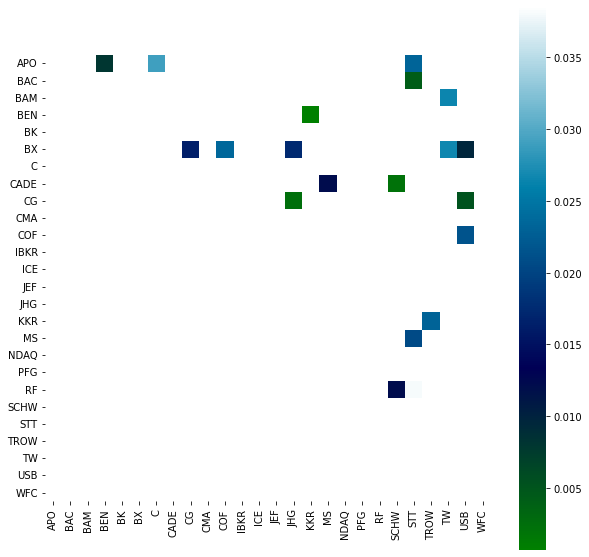

In [65]:
p_value = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs = cointegration_test(df,p_value)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    pvalues,
    xticklabels=new_tickers,
    yticklabels=new_tickers,
    cmap="ocean",
    mask=(pvalues >= 0.05),
    square=True
)
print(pairs)

### Filter For More Significant Pairs
Filter more to get more significant pairs, and eliminate empty cells.

,BEN,C,CG,COF,JHG,KKR,MS,SCHW,STT,TROW,TW,USB
APO,0.008,0.029,nan,nan,nan,nan,nan,nan,0.023,nan,nan,nan
BAC,nan,nan,nan,nan,nan,nan,nan,nan,0.004,nan,nan,nan
BAM,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.027,nan
BEN,nan,nan,nan,nan,nan,0.001,nan,nan,nan,nan,nan,nan
BX,nan,nan,0.016,0.024,0.017,nan,nan,nan,nan,nan,0.027,0.010
CADE,nan,nan,nan,nan,nan,nan,0.012,0.002,0.039,nan,nan,nan
CG,nan,nan,nan,nan,0.002,nan,nan,nan,nan,nan,nan,0.005
COF,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.021
KKR,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.023,nan,nan
MS,nan,nan,nan,nan,nan,nan,nan,nan,0.021,nan,nan,nan


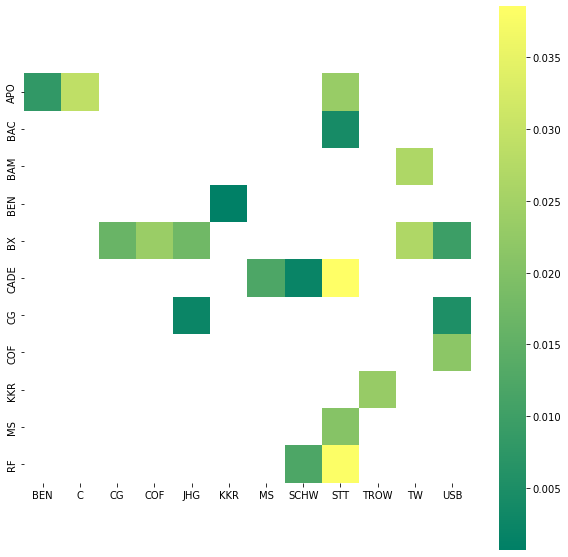

In [66]:
mask_matrix = (pvalues >= 0.05) # possible to increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= new_tickers, columns = new_tickers)
scores_df = pd.DataFrame(scores, index= new_tickers, columns = new_tickers)
pvalues_df = pd.DataFrame(pvalues, index= new_tickers, columns = new_tickers)

df_f = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_f = df_f.dropna(how='all')

def gold_apply(x):
    color = {True: "background-color: #c78f2e", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color

# Another way to format table is applymap
# def color_map(x):
#     return f"color: {'red' if x > 0 else 'white'}"

# df_f.style.applymap(color_map)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_f,
    xticklabels=df_f.columns,
    yticklabels=df_f.index,
    cmap="summer",
    square=True
)
df_f.style.format(precision=3)\
.apply(gold_apply)

### EXERCISE: Get List/Dic of Pairs

In [67]:
x_list = df_f.index.tolist()
y_list = df_f.columns.tolist()

new_pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_f.iloc[i,j]>0:
            new_pairs_list.append((x_list[i], y_list[j]))

new_pairs_list

[('APO', 'BEN'),
 ('APO', 'C'),
 ('APO', 'STT'),
 ('BAC', 'STT'),
 ('BAM', 'TW'),
 ('BEN', 'KKR'),
 ('BX', 'CG'),
 ('BX', 'COF'),
 ('BX', 'JHG'),
 ('BX', 'TW'),
 ('BX', 'USB'),
 ('CADE', 'MS'),
 ('CADE', 'SCHW'),
 ('CADE', 'STT'),
 ('CG', 'JHG'),
 ('CG', 'USB'),
 ('COF', 'USB'),
 ('KKR', 'TROW'),
 ('MS', 'STT'),
 ('RF', 'SCHW'),
 ('RF', 'STT')]

In [68]:
new_pairs_str =[] # list of pairs as string A-B

for column in df_f:
    toprint = df_f.index[df_f[column]>0].tolist()
    new_pairs_str.append([column + "-" + s for s in toprint])
    
new_pairs_str

[['BEN-APO'],
 ['C-APO'],
 ['CG-BX'],
 ['COF-BX'],
 ['JHG-BX', 'JHG-CG'],
 ['KKR-BEN'],
 ['MS-CADE'],
 ['SCHW-CADE', 'SCHW-RF'],
 ['STT-APO', 'STT-BAC', 'STT-CADE', 'STT-MS', 'STT-RF'],
 ['TROW-KKR'],
 ['TW-BAM', 'TW-BX'],
 ['USB-BX', 'USB-CG', 'USB-COF']]

In [69]:
new_pairs_dic= {} # list of pairs as dictionary {'A':['B','C']}

for column in df_f:
    new_pairs_dic[column] = df_f.index[df_f[column]>0].tolist()

new_pairs_dic

{'BEN': ['APO'],
 'C': ['APO'],
 'CG': ['BX'],
 'COF': ['BX'],
 'JHG': ['BX', 'CG'],
 'KKR': ['BEN'],
 'MS': ['CADE'],
 'SCHW': ['CADE', 'RF'],
 'STT': ['APO', 'BAC', 'CADE', 'MS', 'RF'],
 'TROW': ['KKR'],
 'TW': ['BAM', 'BX'],
 'USB': ['BX', 'CG', 'COF']}

### Save to file
Save dataframa as pickle to use for the next steps

In [70]:
df_f.to_pickle("pairs_to_download.pkl")